# Example notebook: Visualizing the Solar System with a Starshade (HWO 60m)

This notebook demonstrates how to load a solar system scene simulated with ExoVista and visualize it using the HWO (Habitable Worlds Observatory) 60m starshade.

In [2]:
import os
import sys
notebook_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(notebook_dir, ".."))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

In [3]:
from astropy.io import fits
import numpy as np
import download_exovista
download_exovista.exovista_scenes_file()
from pystarshade.data.scenes.Scene import *
from pystarshade.diffraction.util import mas_to_rad, au_to_meter, pc_to_meter, data_file_path #, flux_to_mag,
from pystarshade.propagator import StarshadeProp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import rc
local_zodi_mag_v_arcsec2 = 22.5 #local zodi

Scene.py already exists in /home/ielo/sandbox/test_/PyStarshade/pystarshade/data/scenes.


### PyStarshade Optical Model Summary

PyStarshade simulates light propagation through a starshade and telescope using a Fourier optics model in two stages:

1. **Starshade to Telescope (Fresnel Diffraction)**:  
   Light from point sources (exoplanetary scene) undergoes incoherent Fresnel diffraction past the starshade. For an on-axis source, the field at the telescope aperture is derived from a Fourier transform of the starshade mask, at coordinates scaled by wavelength $\lambda$ and distance $z$. Diffraction occurs for sources within a region of $\sim 4 \cdot R_{ss} / z$ angular separation in the source-field, where $R_{ss}$ is the starshade radius.

2. **Telescope to Focal Plane (Fraunhofer Diffraction)**:  
   The diffracted field is masked by, and diffracted past the telescope aperture to the focal plane, forming the point-spread function (PSF). The PSF is calculated via a Fourier transform of the aperture field on coordinates scaled by the telescope’s focal length $f$ and wavelength $\lambda$.

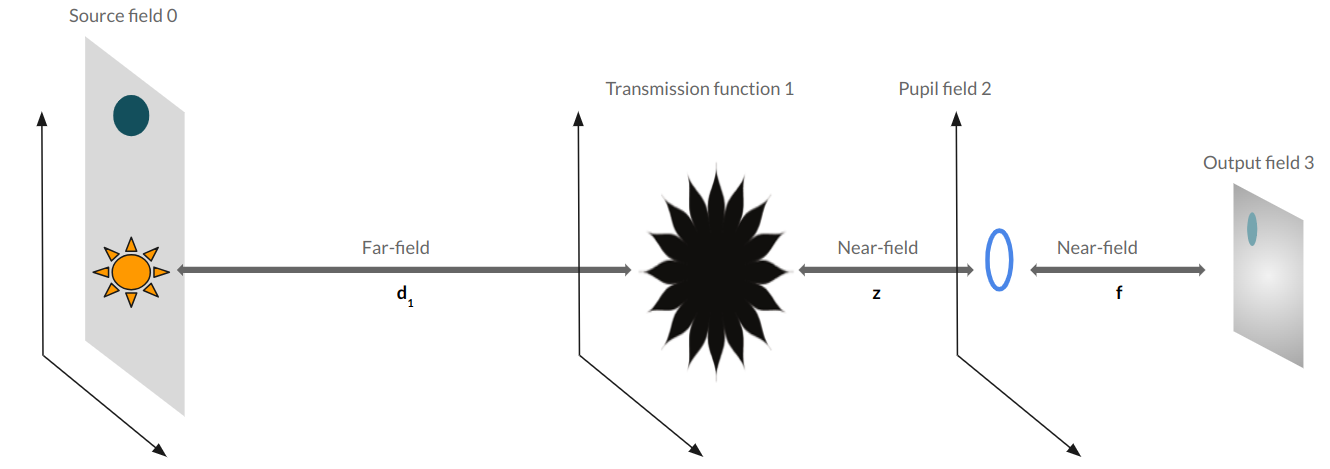

### Using PyStarshade

PyStarhade stores files/parameters of a mission concept (or a Design Reference Mission) in `data/drm.py`. The choice of telescope aperture is decoupled from the DRM (however, the size of the aperture must be defined in the DRM). We can load the drm file and inspect the Roman (formerly WFIRST) rendezvous mission parameters:

In [2]:
from pystarshade.data.drm import telescope_params
# Load the 'wfirst' parameters
wfirst_params = telescope_params['wfirst']

# Print the WFIRST parameters
print("WFIRST Telescope Parameters:")
for key, value in wfirst_params.items():
    print(f"{key}: {value}")

WFIRST Telescope Parameters:
focal_length_lens: 30
diameter_telescope_m: 2.36
radius_lens: 1.18
dist_ss_t: [37242256.68350351 26120376.72633376 21191429.69119565]
iwa_mas: 72
num_pet: 16
ss_radius: 13
grey_mask_dx: ['01m', '005m', '002m', '001m', '0005m']
dx_: [0.01, 0.005, 0.002, 0.001, 0.0005]
wl_bands: [[425, 552], [606, 787], [747, 970]]
iwa: [ 72.         102.65711361 126.53428864]


### Starshade Masks

The starshade mask itself is not generated by PyStarshade. Instead, we’ve collected masks from various sources (e.g. SISTERS, diffraq) and interpolated/upsampled them into grey‑scale masks stored in: `data/masks/starshade_masks`.


The parameter `grey_mask_dx` describes the pixel sampling in physical units of a mask file. For example:
```text
"01m" → Δs = 0.01 m

[Text(0.5, 1.0, 'HWO'), Text(0.5, 0, 'x [m]'), Text(0, 0.5, 'y [m]')]

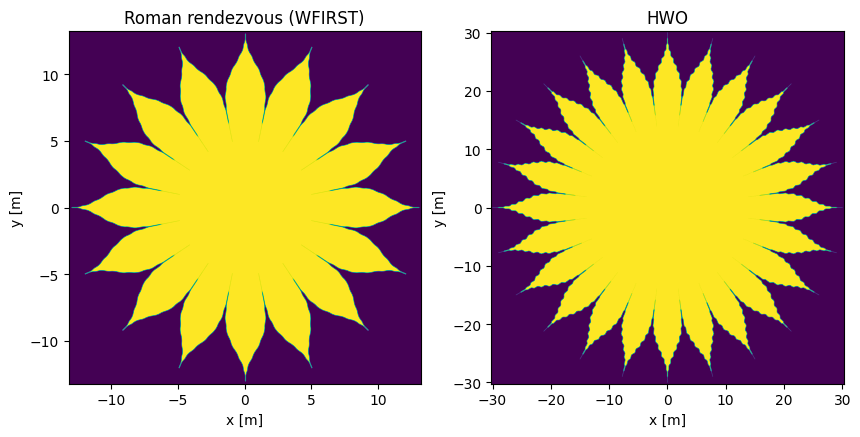

In [37]:
import matplotlib.pyplot as plt
from pystarshade.apodization.apodize import qu_mask_to_full

drm = 'wfirst'
wfirst_starshade = StarshadeProp(drm = drm)
wfirst_starshade.set_mission_params(drm, mask_choice=0, band_i=0)
d_x_w = wfirst_starshade.d_x
ss_mask_fname = wfirst_starshade.ss_mask_fname_partial + '_qu.npz'
starshade_qu = np.load(ss_mask_fname)
wfirst_starshade = qu_mask_to_full(starshade_qu['grey_mask'])

drm = 'hwo'
hwo_starshade = StarshadeProp(drm = drm)
hwo_starshade.set_mission_params(drm, mask_choice=0)
d_x_h = hwo_starshade.d_x
ss_mask_fname = hwo_starshade.ss_mask_fname_partial + '_qu.npz'
starshade_qu = np.load(ss_mask_fname)
hwo_starshade = qu_mask_to_full(starshade_qu['grey_mask'])

N1 = wfirst_starshade.shape[0]
N2 = hwo_starshade.shape[0]

extent1 = (-N1*d_x_w/2, N1*d_x_w/2, -N1*d_x_w/2, N1*d_x_w/2)
extent2 = (-N2*d_x_h/2, N2*d_x_h/2, -N2*d_x_h/2, N2*d_x_h/2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

im1 = ax1.imshow(wfirst_starshade, extent=extent1, origin='lower', aspect='equal')
ax1.set(title='Roman rendezvous (WFIRST)', xlabel='x [m]', ylabel='y [m]')

im2 = ax2.imshow(hwo_starshade, extent=extent2, origin='lower', aspect='equal')
ax2.set(title='HWO', xlabel='x [m]', ylabel='y [m]')


### PSF Basis

PyStarshade comes with **pre‑computed diffracted fields**  at the telescope aperture for the HWO starshade (stored in `data/fields` via the git‑LFS install), so you can immediately generate PSF basis for different telescope pupils (e.g. `hex`, `circular`, etc.). These fields are given across the HWO-starshade band $500-1000$ nm, in steps of $\Delta \lambda = 50$ nm. If you want to run this diffraction from scratch over a different/new starshade, consult the documentation. We will not do this here, but one would run the following to generate a full-psf basis saved on disk:

```python
hwo_starshade = StarshadeProp(drm='hwo')
hwo_starshade.gen_pupil_field()
hwo_starshade.gen_psf_basis(pupil_type='hwopupil_onaxis')


### Loading the ExoVista scene

[ExoVista](https://github.com/alexrhowe/ExoVista) can be used to create realistic planetary scenes for our imaging simulations - this tool can generate spectral and time-dependent scenes which incorporate realistic exoplanetary demographics (based on Kepler) and exozodiacal dust. We use scenes of the solar system at 10 parsecs, viewed face-on and at 60 degrees inclination. These scenes are then passed to PyStarshade to simulate observations with different telescope pupils (off-axis and on-axis) and starshade designs. This allows us to explore how instrumental choices impact the final images and the detectability of planets.

A number of pre-simulated scenes are included in the 'data/scenes' directory, including solar system scenes. We use the script 'data/scenes/Scene.py' to load and construct these scenes.

**Note:** The default source pixel size in ExoVista is 2 MAS. In our simulations, we use this same pixel size but adjust the number of pixels to simulate a larger field. If you simulate your own scenes and want to vary either of these parameters, modify the values 'pixscale' and 'npix' in 'Exovista/src/settings.py'.

In [4]:
fname_60 = '999-HIP_-TYC_SUN-mv_4.83-L_1.00-d_10.00-Teff_5778.60.fits' #solar system at 60 deg inclination
fname_faceon = '999-HIP_-TYC_SUN-mv_4.83-L_1.00-d_10.00-Teff_5778.00.fits' #solar system face-on

In [5]:
# Handle directories and load solar system scene
data_dir = os.path.abspath(os.path.join(notebook_dir, '..', 'pystarshade', 'data'))
file_path = os.path.join(data_dir, 'scenes', fname_faceon)
hdul = fits.open(file_path)
dist_xo_ss = hdul[4].header['dist'] * pc_to_meter
inclination = hdul[2].header['I-0']

Exovista scenes come deconstructed, the code below constructs the scene. 

Magnitude of star:  (-8.510927234262484+0j)
Magnitude at ~ 1 AU:  (23.218504597860893+0j)
inclination:  0.0
number of Zodis:  1.0
Distance from exo-scene to starshade [pc]:  10.0
Number of planets included in scene:  7
Star brightness:  36.849439384832834
Planet brightness:  [0.00000000e+00 1.63112710e-09 1.93913214e-08 4.51523417e-09
 3.39128148e-10 5.67344523e-08 1.03474515e-08 5.44311671e-10]
Plan/Star brightness:  [0.00000000e+00 4.42646381e-11 5.26231112e-10 1.22531964e-10
 9.20307484e-12 1.53962864e-09 2.80803499e-10 1.47712334e-11]
Semi major axis[au]:  [20.0000147   0.66573317  1.04345656  1.38361946  1.95059109  7.00457509
 12.93817012 28.17446303]
wavelength [m] 5.01392186235853e-07
ZODIs:  1.0
Physical extent (AU) 20.02001471578573
1 source pixel is (AU):  0.020000014701084645
Distance of system (pc):  10.0


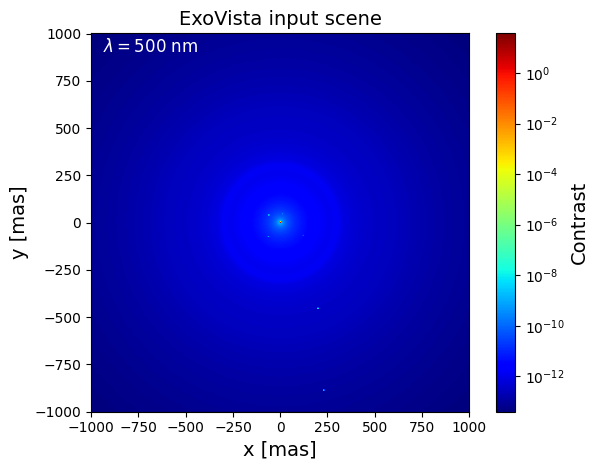

In [6]:
t = 0 # timestep
scene = Scene(file_path)
bg_scene = scene.getDiskImage()
star_xy = scene.getXYstar()
bg_scene[:,int(star_xy[0]), int(star_xy[1])] += scene.getStarSpec(time = t)

planet_xy = scene.getXYplanets(time = t).astype(int)
planet_spectra = scene.getPlanetSpec(time = t)
star_spectra = scene.getStarSpec(time = t)
ds_mas = scene.getPixScale()

stel_ang_diam = scene.getAngDiam()
ds = dist_xo_ss * ds_mas * mas_to_rad
ds_au = ds / au_to_meter

wl_range = scene.lambdas * 1e-6 

N_wl = len(wl_range)
N_dust = np.shape(bg_scene)[1]
N_dust_half = N_dust//2

N_s = 1001
extended_field = np.zeros((N_wl, N_s, N_s), dtype=np.complex128) 
half_N = N_s // 2
half_in_N = N_dust // 2
bit_arr = N_dust % 2 
extended_field[:, half_N - half_in_N : half_N + half_in_N + bit_arr,
       half_N - half_in_N : half_N + half_in_N + bit_arr] = bg_scene

# Define the wavelength (lam_ref), make sure this matches up with the PSF basis

lam_ref = np.float64(5*1e-7)
wl_str = int(lam_ref*1e9)
w_i = np.where(wl_range >= lam_ref)[0][0]
wl = wl_range[w_i]

n_planet = 0

for i in range(scene.nplanets):
    if np.all(planet_xy[i] - N_dust_half + half_N  <= N_s-1) and np.all(planet_xy[i] - N_dust_half + half_N >= 0):
        extended_field[:, planet_xy[i, 1]- N_dust_half + half_N , planet_xy[i, 0]- N_dust_half + half_N] += planet_spectra[i]
        n_planet +=1

source_field = extended_field[w_i]

print ('Magnitude of star: ', -2.5*np.log10((500**2)*source_field[int(star_xy[0]), int(star_xy[1])])+8.9)
print ('Magnitude at ~ 1 AU: ', - 2.5*np.log10((500**2)*source_field[int(star_xy[0]) - 50, int(star_xy[1])]) + 8.9)
print ('inclination: ', hdul[2].header['I-0'])
print ('number of Zodis: ', hdul[2].header['NZODIS-0'])
print ('Distance from exo-scene to starshade [pc]: ', dist_xo_ss/pc_to_meter)
print ('Number of planets included in scene: ', n_planet)
print ('Star brightness: ', star_spectra[w_i])
print ('Planet brightness: ', planet_spectra[:,w_i])
print ('Plan/Star brightness: ', (planet_spectra[:,w_i]/(star_spectra[w_i])))
print ('Semi major axis[au]: ', np.sqrt(2)*ds_au*np.hypot(planet_xy[:, 0] - N_dust_half, planet_xy[:, 1] - N_dust_half))
print ('wavelength [m]', wl)
print ('ZODIs: ', hdul[2].header['NZODIS-0'])
print ('Physical extent (AU)', N_s * ds * (1/au_to_meter))
print ( '1 source pixel is (AU): ', ds/au_to_meter)
print ('Distance of system (pc): ', dist_xo_ss/pc_to_meter)

plt.figure()
plt.title('ExoVista input scene', fontsize=14)
plt.text(-940, 900, r'$\lambda = $%s nm' % (wl_str), color='white', fontsize=12)
plt.imshow(np.abs(source_field),  norm=LogNorm(), cmap='jet', extent=(-N_s, N_s, -N_s, N_s))
plt.xlabel('x [mas]', fontsize=14)
plt.ylabel('y [mas]', fontsize=14)
cbar = plt.colorbar()
cbar.set_label('Contrast', fontsize=14)
plt.tight_layout()
plt.show()

### Simulating Imaging

In this section we load an ExoVista model of our solar system and propagate it through the HWO 60 m starshade + 6 m off‑axis segmented pupil to produce an image at 500 nm. Note, this is the optical brightness and does not incorporate the effect of exposure time and noise, or local zodiacal light. 

The `pupil_type` can be a user-defined npz file or, optionally you can choose one of the pupil apertures from HCIPy: circ, ELT, GMT, TMT, Hale, LUVOIR-A, LUVOIR-B, Magellan, VLT, HiCAT, HabEx, HST, JWST, Keck, hex.

In [9]:
drm = 'hwo'
pupil_type = 'hwopupil_onaxis'
#pupil_type = 'hwopupil_offaxis'
hwo_starshade = StarshadeProp(drm = drm)
hwo_starshade.N_wl = 1 # edit an internal variable so that only a single wavelength PSF basis is calculated
hwo_starshade.gen_psf_basis(pupil_type = pupil_type)
focal_intensity = hwo_starshade.gen_scene(pupil_type, source_field.astype(np.float32), lam_ref, pupil_symmetry = False)

/tmp/ipykernel_177018/2657072232.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  focal_intensity = hwo_starshade.gen_scene(pupil_type, source_field.astype(np.float32), lam_ref, pupil_symmetry = False)


Let's plot this - left is zoomed out and in units of $mag\cdot arcsec^{-2}$, right is zoomed in and left in units of contrast. 

The resulting images reveal Venus, Earth and Mars.

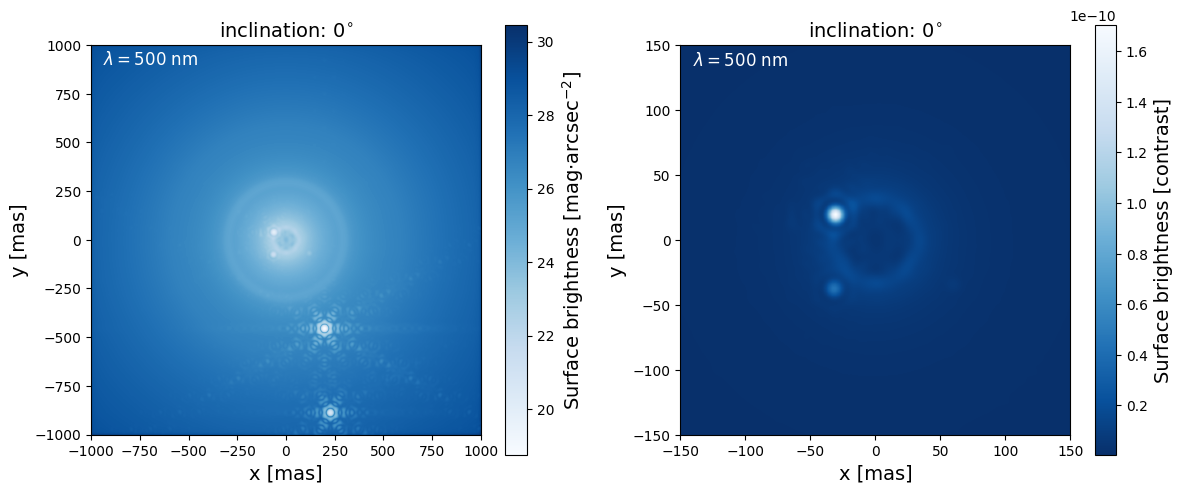

In [11]:
N = np.shape(focal_intensity)[0]
# Add in a median local zodi mag of 23.02 V mag∕arc sec2
def flux_to_mag(flux):
    # 2 mas pixels
    return - 2.5*np.log10((500**2)*flux /  3640	)

region_mas = 150
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

im1 = ax1.imshow(
    flux_to_mag(focal_intensity),
    cmap='Blues',
    extent=(-N, N, -N, N)
)
ax1.set_title(r'inclination: %s$^{\circ}$' % int(inclination), fontsize=14)
ax1.text(-940, 900, r'$\lambda = $500 nm', color='white', fontsize=12)
ax1.set_xlabel('x [mas]', fontsize=14)
ax1.set_ylabel('y [mas]', fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1)
cbar1.set_label(r'Surface brightness [mag$\cdot$arcsec$^{-2}$]', fontsize=14)

zoom = focal_intensity[
    500-region_mas:500+region_mas,
    500-region_mas:500+region_mas
]
im2 = ax2.imshow(
    zoom,
    cmap='Blues_r',
    extent=(-region_mas, region_mas, -region_mas, region_mas)
)
ax2.set_title(r'inclination: %s$^{\circ}$' % int(inclination), fontsize=14)
ax2.text(-region_mas + 10, region_mas-16, r'$\lambda = $500 nm', color='white', fontsize=12)
ax2.set_xlabel('x [mas]', fontsize=14)
ax2.set_ylabel('y [mas]', fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2)
cbar2.set_label('Surface brightness [contrast]', fontsize=14)

plt.tight_layout()
plt.show()

Let's try this with a different aperture!

PSF file does not exist. Generating: 
Generating a new pupil mask.


/tmp/ipykernel_177018/1318963952.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  focal_intensity = hwo_starshade.gen_scene(pupil_type, source_field.astype(np.float32), lam_ref, pupil_symmetry = False)


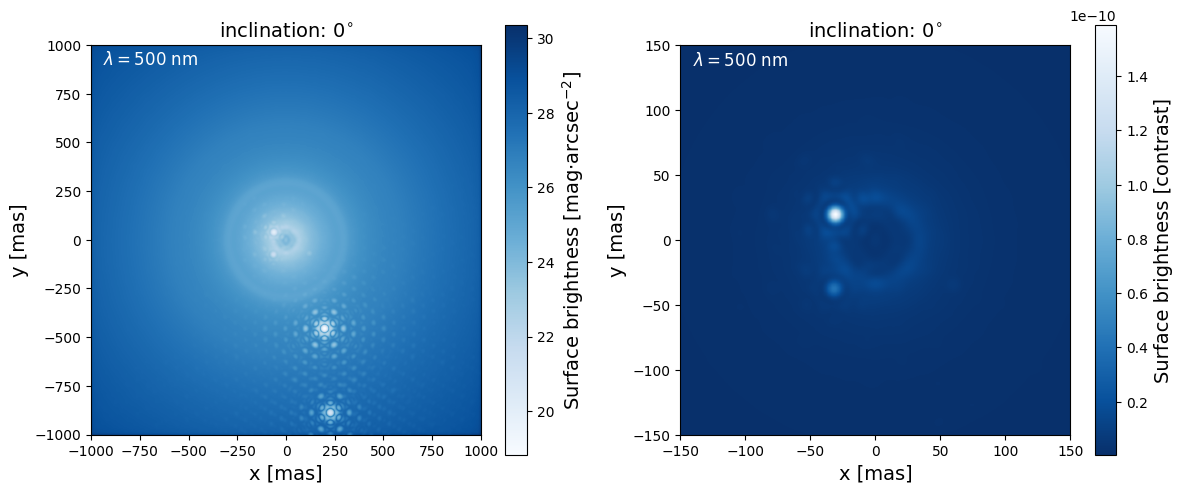

In [13]:
drm = 'hwo'
pupil_type = 'GMT'

hwo_starshade = StarshadeProp(drm = drm)
hwo_starshade.N_wl = 1 # edit an internal variable so that only a single wavelength PSF basis is calculated
hwo_starshade.gen_psf_basis(pupil_type = pupil_type)
focal_intensity = hwo_starshade.gen_scene(pupil_type, source_field.astype(np.float32), lam_ref, pupil_symmetry = False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

im1 = ax1.imshow(
    flux_to_mag(focal_intensity),
    cmap='Blues',
    extent=(-N, N, -N, N)
)
ax1.set_title(r'inclination: %s$^{\circ}$' % int(inclination), fontsize=14)
ax1.text(-940, 900, r'$\lambda = $500 nm', color='white', fontsize=12)
ax1.set_xlabel('x [mas]', fontsize=14)
ax1.set_ylabel('y [mas]', fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1)
cbar1.set_label(r'Surface brightness [mag$\cdot$arcsec$^{-2}$]', fontsize=14)

zoom = focal_intensity[
    500-region_mas:500+region_mas,
    500-region_mas:500+region_mas
]
im2 = ax2.imshow(
    zoom,
    cmap='Blues_r',
    extent=(-region_mas, region_mas, -region_mas, region_mas)
)
ax2.set_title(r'inclination: %s$^{\circ}$' % int(inclination), fontsize=14)
ax2.text(-region_mas + 10, region_mas-16, r'$\lambda = $500 nm', color='white', fontsize=12)
ax2.set_xlabel('x [mas]', fontsize=14)
ax2.set_ylabel('y [mas]', fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2)
cbar2.set_label('Surface brightness [contrast]', fontsize=14)

plt.tight_layout()
plt.show()